### Проект: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

### Цель: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [97]:
# Импортируем библиотеки, которые понадобятся в работе
import pandas as pd # работа с датафреймами
import numpy as np # работа с массивами 
import matplotlib.pyplot as plt # визуализация 
import seaborn as sns # визуализация 
import warnings 
warnings.filterwarnings('ignore') # для удобства работы 
from sklearn.preprocessing  import LabelEncoder # обработка признаков 
from sklearn import preprocessing # обработка признаков
from sklearn import linear_model # построение моделей
from sklearn import tree # построение моделей
from sklearn import ensemble # построение моделей
from sklearn.feature_selection import SelectKBest, f_classif # отбор наиболее важных признаков
from sklearn.ensemble import GradientBoostingClassifier # градиентный бустинг
from sklearn.ensemble import StackingClassifier # стекинг 
from  sklearn.ensemble import IsolationForest # ансамблевые методы 
from sklearn.model_selection import train_test_split # деление выборки 
from sklearn.model_selection import GridSearchCV # оптимизация
import optuna # оптимизация гиперпараметров
from sklearn import metrics # метрики 
from sklearn.metrics import classification_report # метрики

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [98]:
df = pd.read_csv('bank_fin.csv', sep = ';') # подгружаем данные

In [99]:
df.head(5) # посмотрим, как они выглядят

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [100]:
df.info() # проверим, есть ли пропуски
print('Число пропусков в признаке "баланс": ', df['balance'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
Число пропусков в признаке "баланс":  25


In [101]:
# Посмотрим на значения столбца 'job' - здесь пропущенные значения скрыты словом 'unknown'
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [102]:
# Обработаем признак "баланс", убрав лишние знаки
def correct_balance(x):
    x = str(x)
    x = x.replace(' $', '') # убираем знак доллара
    x = x.replace(',', '.') # запятые
    x = x.replace(' ', '') # ненужные пропуски
    return x

df['balance'] = df['balance'].apply(correct_balance)
df['balance'] = df['balance'].astype('float') # приводим к типу float

In [103]:
print('Средний баланс: ', round(df['balance'].mean(), 3))

Средний баланс:  1529.129


In [104]:
# Обработаем пропуски - заполним их медианным значением признака "баланс"
median_balance = df['balance'].median() # находим медиану
df['balance'] = df['balance'].fillna(median_balance) # заполняем пропуск

In [105]:
# Рассчитаем средний баланс после заполнения пропусков
print('Средний баланс: ', round(df['balance'].mean(), 3))

Средний баланс:  1526.936


Перейдем к признакам "работа" и "образование".

In [106]:
# Заменим неявные пропуски признака ("unknown") на моду
mode_job = df['job'].mode()[0] # находим модальное значение признака "работа"
mode_edu = df['education'].mode()[0] # находим модальное значение признака "образование"
df['job'] = df['job'].apply(lambda x: mode_job if x=='unknown' else x) # заменяем пропуски
df['education'] = df['education'].apply(lambda x: mode_edu if x=='unknown' else x) # заменяем пропуски

In [107]:
df['job'].value_counts() # все значения признака "работа"

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [108]:
df['education'].value_counts() # все значения признака "образование"

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

Посмотрим, каков средний баланс для клиентов с наиболее популярной работой и уровнем образования.

In [109]:
# Отбираем клиентов из сферы менеджмента со средним образованием
df_popular = df[(df['job'] == 'management') & (df['education'] == 'secondary')]
print('Средний баланс:', round(df_popular['balance'].mean(), 3))

Средний баланс: 1598.883


Поработаем с выбросами.

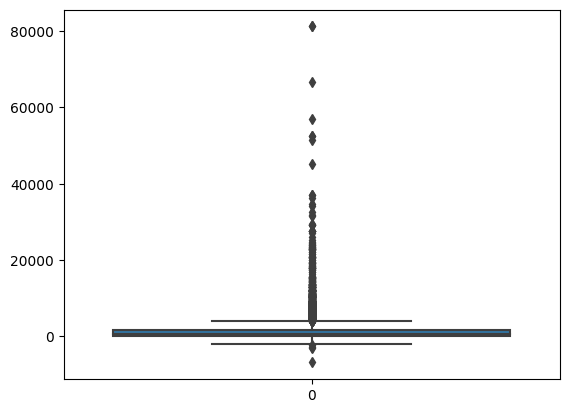

In [110]:
# Посмотрим на распределение признака "баланс"
sns.boxplot(df['balance']);

Поработаем с выбросами.

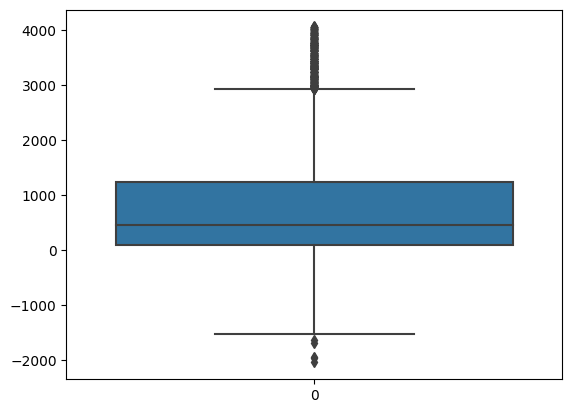

In [111]:
# Используем метод Тьюки
quartile_1, quartile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75)  # рассчитаем квартили
iqr = quartile_3 - quartile_1 
lower_bound = quartile_1 - 1.5 * iqr # вычисляем границы 
upper_bound = quartile_3 + 1.5 * iqr
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)] # избавляемся от выбросов
sns.boxplot(df['balance']); # смотрим на результат на графике

In [112]:
print(df.shape) # размер датафрейма после удаления выбросов

(10105, 17)


## Часть 2:  Разведывательный анализ

Посмотрим на соотношение клиентов с депозитом и без.

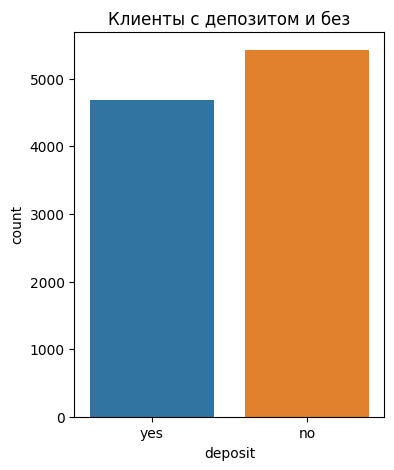

In [113]:
fig, ax = plt.subplots(figsize=(4, 5))
sns.countplot(x=df['deposit']).set(title='Клиенты с депозитом и без');

Посмотрим на количественные переменные.

In [114]:
df.describe() # выведем статистику

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


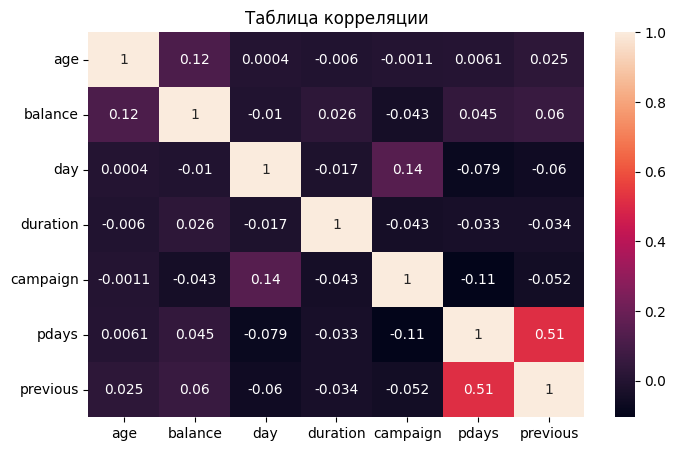

In [115]:
# составим таблицу корреляции
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True).set(title='Таблица корреляции');

Сильной корреляции не наблюдается.

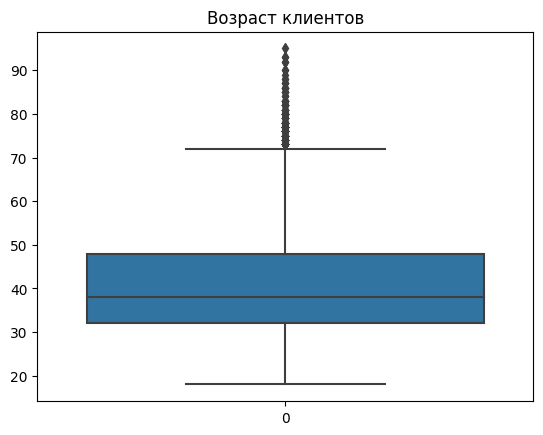

In [116]:
# Посмотрим на распрееление признака "возраст"
sns.boxplot(df['age']).set(title='Возраст клиентов');

Явных выбросов нет.

In [117]:
# Посмотрим на сферы деятельности клиентов (в процентнах от общего числа)
print(df['job'].value_counts(normalize=True) * 100)

management       22.909451
blue-collar      17.882237
technician       16.209797
admin.           12.330529
services          8.589807
retired           6.561108
self-employed     3.542801
unemployed        3.285502
student           3.226126
entrepreneur      2.968827
housemaid         2.493815
Name: job, dtype: float64


Среди клиентов банка много офисных работников, а меньше всего - домохозяев, студентов и предпринимателей / самозанятых (то есть людей с менее стабильным заработком).

In [118]:
# Теперь посмотрим на семейное положение клиентов
print(df['marital'].value_counts(normalize=True) * 100)

married     56.556160
single      31.796141
divorced    11.647699
Name: marital, dtype: float64


In [119]:
# Образование клиентов
print(df['education'].value_counts(normalize=True) * 100)

secondary    54.596734
tertiary     32.053439
primary      13.349827
Name: education, dtype: float64


Большинство клиентов имеют среднее образование.

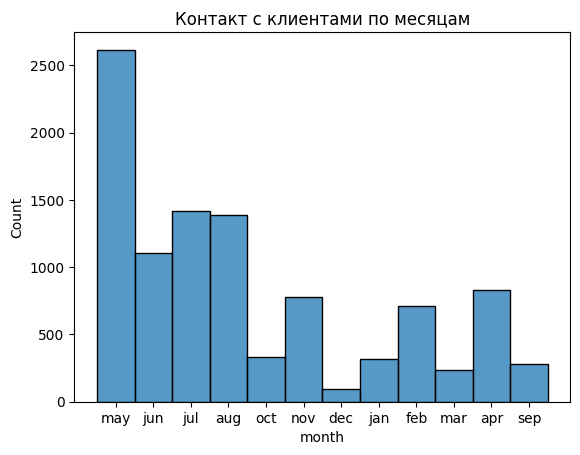

In [120]:
# Месяцы, когда банк связывался с клиентами
sns.histplot(df['month']).set(title='Контакт с клиентами по месяцам');

Очень высокая активность наблюдается в мае, крайне низкая - в декабре (вероятно, из-за праздников).

Посмотрим на данные с точки зрения успеха или неудачи прошлой маркетинговой компании ('poutcome').

In [121]:
# 'deposit' указывает на успех или неудачу текущей маркетинговой кампании
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

Мы видим, что в случае успеха предыдущей маркетинговой кампании ('success'), нынешняя кампаниия тоже успешна (соотношение 'yes' и 'no').
Далее мы посмотрим, как успех маркетинговой кампании зависит от месяца.

In [122]:
# Сгруппируем данные по месяцам и посмотрим на успехи текущей кампании 
df_month = df.groupby('month')['deposit'].value_counts(normalize=True) * 100 
df_month.sort_values()

month  deposit
dec    no          9.677419
mar    no         10.126582
sep    no         16.546763
oct    no         18.507463
may    yes        32.136034
apr    no         38.192771
jan    yes        39.184953
jul    yes        41.043724
nov    yes        41.538462
aug    yes        44.043321
jun    yes        45.108696
feb    no         45.557123
       yes        54.442877
jun    no         54.891304
aug    no         55.956679
nov    no         58.461538
jul    no         58.956276
jan    no         60.815047
apr    yes        61.807229
may    no         67.863966
oct    yes        81.492537
sep    yes        83.453237
mar    yes        89.873418
dec    yes        90.322581
Name: deposit, dtype: float64

Наиболее успешные кампании проходили в декабре, марте, сентябре и октябре, но это также месяцы с наименее активными кампаниями. Наименее успешен месяц май (самый активный месяц, как мы выяснили выше).

Обработаем признак "возраст". Распределим всех клиентов по возрастным категориям.

In [123]:
def get_age(x): # создадим функцию распределения по возрастным категориям
    if x > 60:
        return '60+'
    elif x > 50:
        return '50-60'
    elif x > 40:
        return '40-50'
    elif x > 30:
        return '30-40'
    else:
        return '< 30'

df['age_group'] = df['age'].apply(get_age) # применяем функцию

In [124]:
df['age_group'].value_counts() # теперь клиенты банка распределены по возрастным группам

30-40    3842
40-50    2255
< 30     1870
50-60    1625
60+       513
Name: age_group, dtype: int64

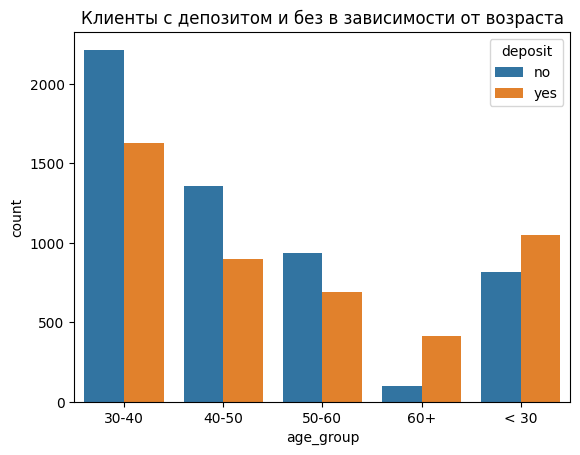

In [125]:
# Посмотрим на возрастные группы с точки зрения открытых / не открытых депозитов
df_age = df.groupby('age_group', as_index=False)['deposit'].value_counts()
sns.barplot(data=df_age, x='age_group', y='count', hue='deposit').set(title='Клиенты с депозитом и без в зависимости от возраста');

Как можно заметить, в возрастных группах "до 30" и "за 60" маркетинговая кампания имела наибольший успех.

Построим графики, позволяющие увидеть, как связан результат маркетинговой кампании и семейное положение, образование и работа клиента.

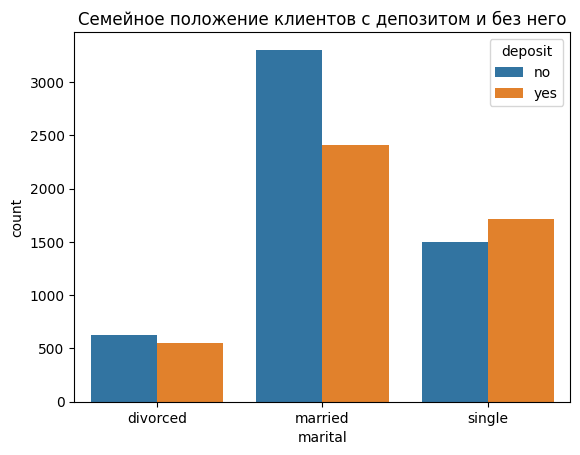

In [126]:
df_marital = df.groupby('marital', as_index=False)['deposit'].value_counts()
sns.barplot(data=df_marital, x='marital', y='count', hue='deposit').set(title='Семейное положение клиентов с депозитом и без него');

Среди одиноких клиентов преобладает число открывших депозитов, а разведенные и в еще большей степени - состоящие в браки клиенты скорее отказываются от открытия депозита. Это можно связать с данными о возрасте: мы видели, что депозит чаще открывают люди за 60 и люди моложе 30 лет, как раз они чаще одиноки, чем категория 30-60. 

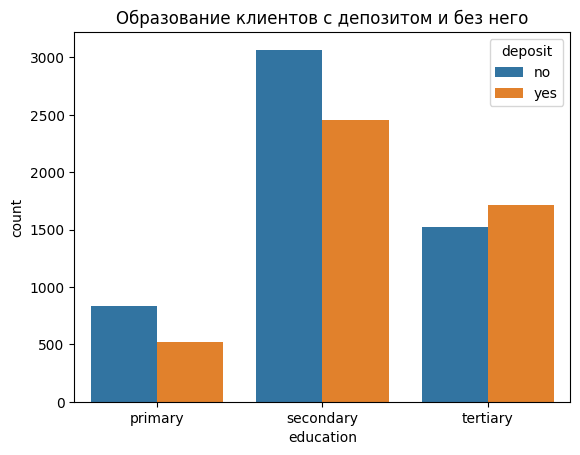

In [127]:
df_education = df.groupby('education', as_index=False)['deposit'].value_counts()
sns.barplot(data=df_education, x='education', y='count', hue='deposit').set(title='Образование клиентов с депозитом и без него');

Депозит склонны открывать люди с высшим образованием. Можно предположить, что среди одиноких людей до 30 много студентов и аспирантов. 

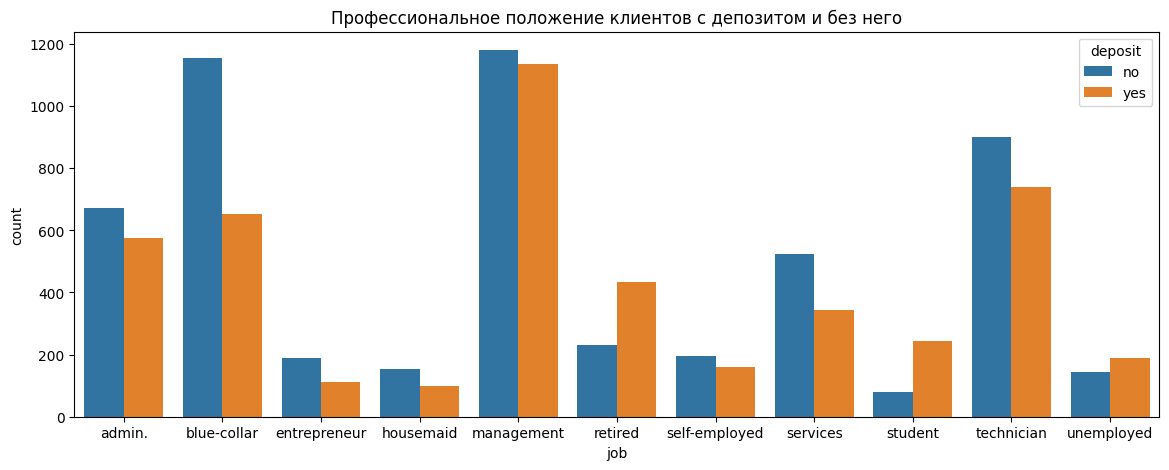

In [128]:
fig, ax = plt.subplots(figsize=(14, 5))
# sns.histplot(data=df, x='job', hue='deposit').set(title='Job');
df_job = df.groupby('job', as_index=False)['deposit'].value_counts()
sns.barplot(data=df_job, x='job', y='count', hue='deposit').set(title='Профессиональное положение клиентов с депозитом и без него');

Итак, мы видим, что среди пенсионеров много тех, кто открыл депозит (мы это также видели при изучении данных о возрасте - это люди за 60), также много обладателей депозита среди студентов (люди до 30). Много открывших депозит и в категории безработных - вероятно, это также молодые люди до 30 лет.

Посмотрим повнимательнее на пересечения категорий семейного положения, образования и наличия/отсутствия депозита.

In [129]:
# Разделим всех клиентов на две категории: открывших депозит и нет
df_yes = df[df['deposit'] == 'yes'] # клиенты, открывшие депозит
df_no = df[df['deposit'] == 'no'] # клиенты без депозита

In [130]:
# Создадим сводную таблицу для тех, кто открыл депозит
pivot_1 = pd.crosstab(index=df_yes['marital'], columns=df_yes['education'])

In [131]:
pivot_1 # посмотрим на нее 

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


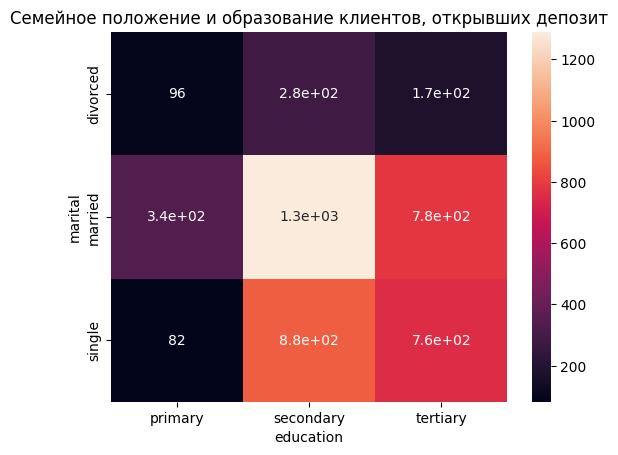

In [132]:
# Построим тепловую карту
sns.heatmap(pivot_1, annot=True).set(title='Семейное положение и образование клиентов, открывших депозит');

Итак, среди клиентов, открывших депозит, преобладают состоящие в браке люди, имеющие среднее образование. Также много одиноких клиентов со средним образованием, а также состоящих в браке и одиноких клиентов с высшим образованием.

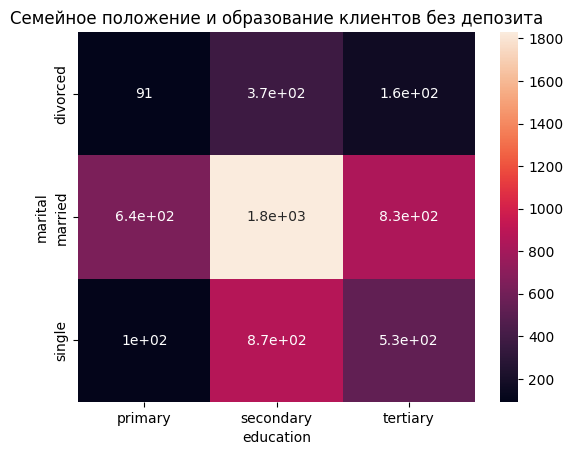

In [133]:
# Теперь составим таблицу для клиентов, не имеющих депозит
pivot_2 = pd.crosstab(index=df_no['marital'], columns=df_no['education'])
# Построим тепловую карту
sns.heatmap(pivot_2, annot=True).set(title='Семейное положение и образование клиентов без депозита'); 

Среди этих клиентов также преобладают состоящие в браке люди со средним образованием. 

## Часть 3: преобразование данных

In [134]:
# Преобразуем признак "образование"
le = preprocessing.LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df['education'].value_counts() # смотрим на результат

1    5517
2    3239
0    1349
Name: education, dtype: int64

In [135]:
# Аналогично поступаем с признаком "возрастная группа"
df['age_group'] = le.fit_transform(df['age_group'])
df['age_group'].value_counts() # выводим результат 

0    3842
1    2255
4    1870
2    1625
3     513
Name: age_group, dtype: int64

In [136]:
# Закодируем целевую переменную (1 или 0)
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [137]:
# Аналогично закодируем другие переменные (1 - да, 0 - нет)
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0) # имеется ли просроченный кредит 
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0) # имеется ли кредит на жилье
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0) # имеется ли кредит на личные нужды

Теперь создадим dummy-переменные для признаков 'job', 'marital', 'contact', 'month', 'poutcome'.

In [138]:
df_dum = pd.get_dummies(df) # обработаем все эти признаки разом

In [139]:
df_dum.info() # посмотрим на получившийся датафрейм

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

In [140]:
df = df_dum # для удобства вернем изначальное название датафрейма

In [141]:
corr = df.corr() # создаем матрицу корреляций
# Модифицируем матрицу, чтобы посмотреть на взаимосвязь признаков с целевой переменной
new_corr = corr['deposit'].reset_index() 
sort_corr = new_corr.sort_values('deposit', ascending=False) # посмотрим на признаки с наиболее высокой корреляцией с целевой переменной
sort_corr.head() # выведем топ-5

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


Сильной корреляции признаков с целевой переменной нет.

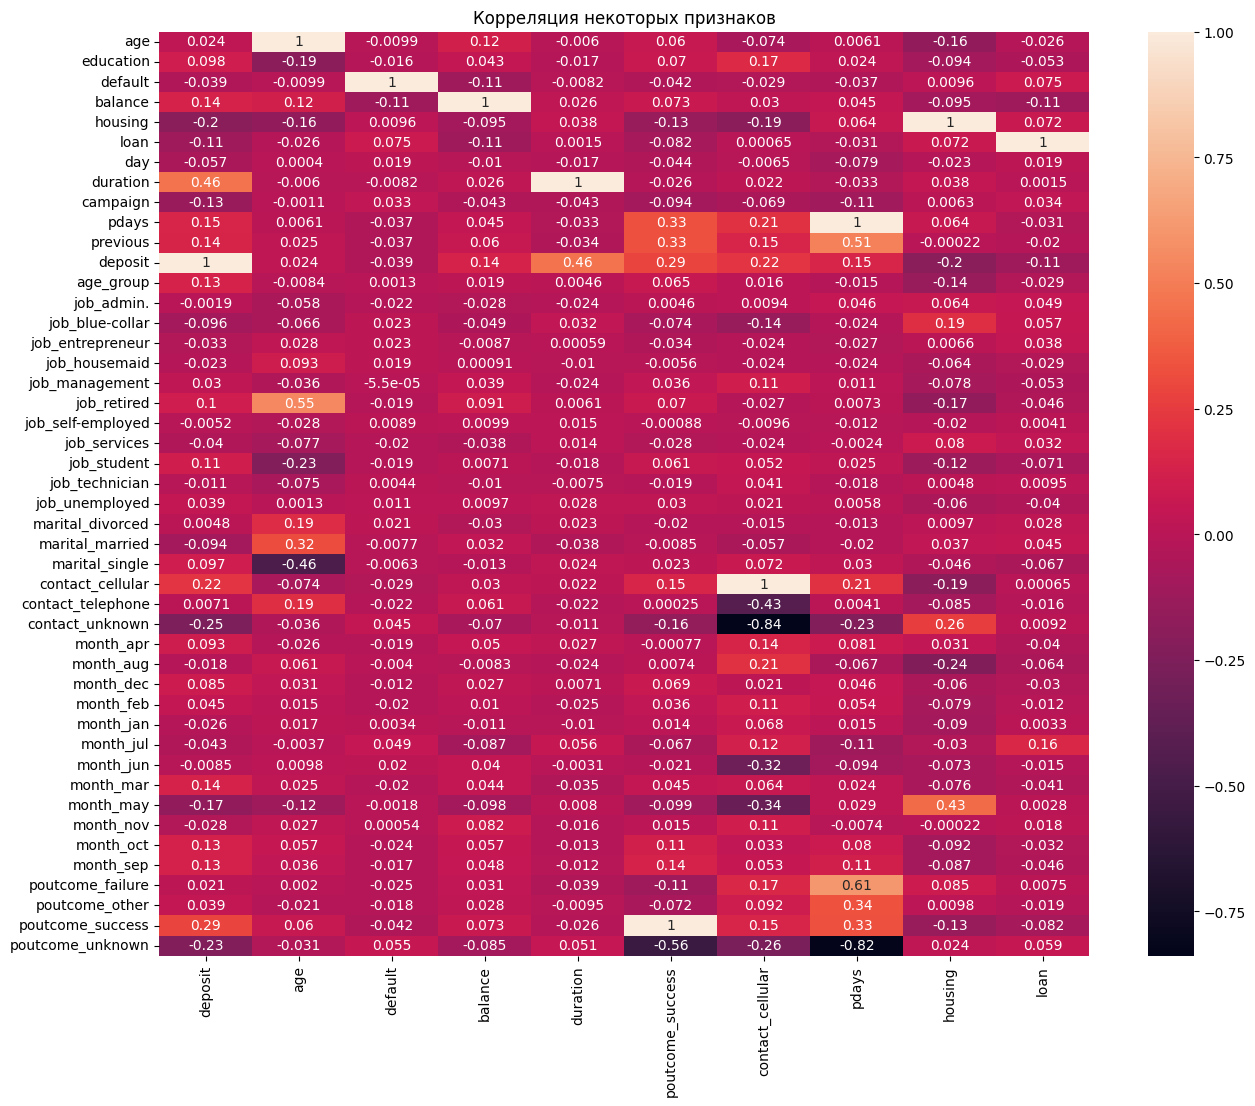

In [142]:
# Признаков очень много, поэтому для тепловой карты отберем лишь 10 
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr[[
    'deposit', 'age', 'default', 'balance', 'duration', 'poutcome_success',
    'contact_cellular', 'pdays', 'housing', 'loan']], annot=True).set(title='Корреляция некоторых признаков');

Мультиколлинеарность не наблюдается, но есть сильная коореляция между некоторыми признаками (например, "результат прошлой маркетинговой кампании неизвестен" и "количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании").

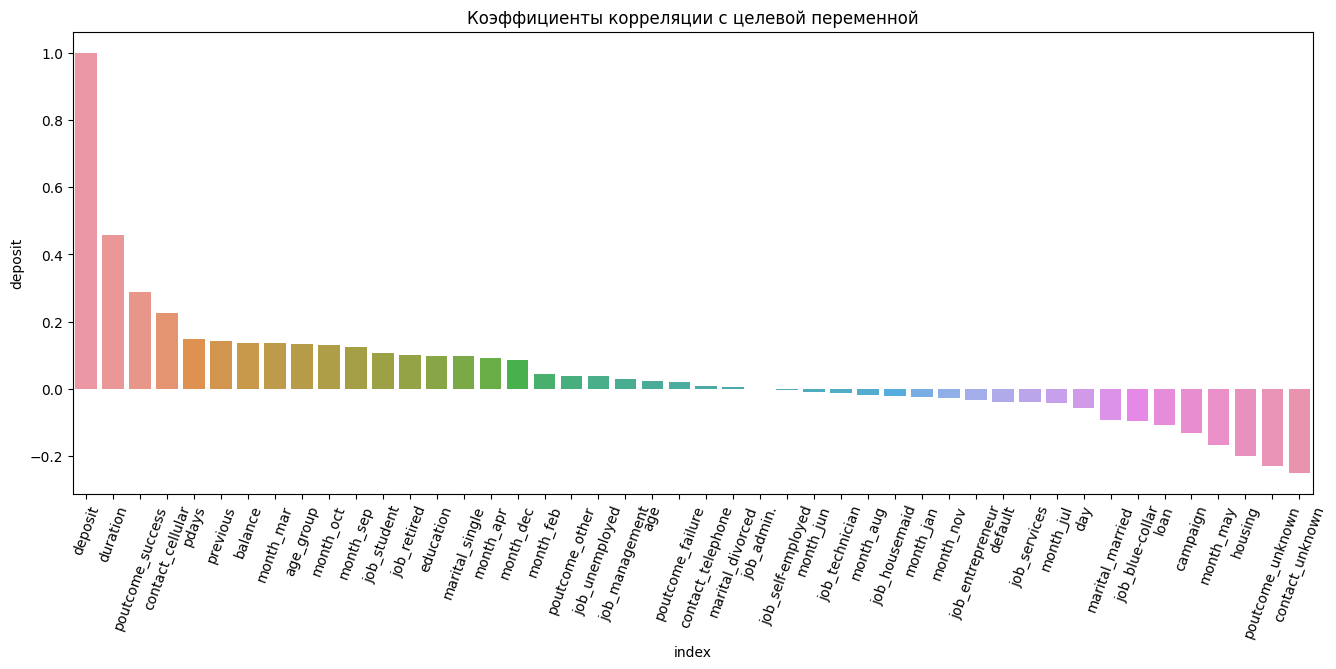

In [143]:
# Теперь построим столбчатую диаграмму для ранжирования коэффициентов корреляции с целевой переменной
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x=sort_corr['index'], y=sort_corr['deposit']).set(title='Коэффициенты корреляции с целевой переменной');
plt.xticks(rotation=70);

In [144]:
# Разобьем выборку на предикаторы и целевую переменную
X = df.drop(['deposit'], axis=1) # предикаторы 
y = df['deposit'] # целевая переменная 

# Теперь разобьем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

Признаков очень много, поэтому мы отберем 15 тех, что сильнее всего связаны с целевой переменной.

In [145]:
selector = SelectKBest(k=15, score_func=f_classif) 
selector.fit(X_train, y_train) # отбираем 15 признаков
selector.get_feature_names_out() # выводим названия отобранных признаков

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [146]:
cols = list(selector.get_feature_names_out()) # сделаем список отобранных признаков

In [147]:
# Проведем нормализацию признаков
X_test = X_test[cols] # выберем только наиболее важные признаки 
X_train = X_train[cols]

mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train) 
X_train_scaled = mm_scaler.transform(X_train) # нормализуем обучающую выборку
X_test_scaled = mm_scaler.transform(X_test) # нормализуем тестовую выборку

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Начнем с логистической регрессии.

In [148]:
log_model = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42) # создаем модель
log_model.fit(X_train_scaled, y_train) # обучаем ее
y_pred_train = log_model.predict(X_train_scaled) # делаем предсказание на обучающей выборке
y_pred_test = log_model.predict(X_test_scaled) # делаем предсказание на тестовой выборке

print('Метрики для тестовой выборки: \n', '\n', classification_report(y_test, y_pred_test)) # выводим метрики для тестовой выборки 
print('Метрики для обучающей выборки: \n', '\n', classification_report(y_train, y_pred_train)) # выводим метрики для обучающей выборки 

Метрики для тестовой выборки: 
 
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Метрики для обучающей выборки: 
 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770



Теперь попробуем построить решающие деревья. 

In [149]:
t_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42) # создаем модель
t_model.fit(X_train_scaled, y_train) # обучаем ее 
y_pred_train = t_model.predict(X_train_scaled) # делаем предсказание для обучающей выборки 
y_pred_test = t_model.predict(X_test_scaled) # делаем предсказание для тестовой выборки

print('Метрики для тестовой выборки: \n', '\n', classification_report(y_test, y_pred_test)) # выводим метрики для тестовой выборки 
print('Метрики для обучающей выборки: \n', '\n', classification_report(y_train, y_pred_train)) # выводим метрики для обучающей выборки 

Метрики для тестовой выборки: 
 
               precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335

Метрики для обучающей выборки: 
 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



Очевидно, что произошло переобучение. Попробуем подобрать оптимальную величину для глубины деревьев.

In [150]:
# Построим модель заново, на этот раз добавим максимальную глубину деревьев
t_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
t_model.fit(X_train_scaled, y_train) # обучаем модель
y_pred_train = t_model.predict(X_train_scaled) # делаем предсказание для обучающей выборки
y_pred_test = t_model.predict(X_test_scaled) # делаем предсказание для тестовой выборки 

print('Метрики для тестовой выборки: \n', '\n', classification_report(y_test, y_pred_test)) # выводим метрики для тестовой выборки 
print('Метрики для обучающей выборки: \n', '\n', classification_report(y_train, y_pred_train)) # выводим метрики для обучающей выборки

Метрики для тестовой выборки: 
 
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Метрики для обучающей выборки: 
 
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.77      0.86      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770



Переобучения не наблюдается.

Проведем оптимизацию гиперпараметров.

In [151]:
# Создадим словарь с гиперпараметрами 
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42), # работаем с деревьями решений
    param_grid=param_grid,
    cv=5, # фолды для кросс-валидации 
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train) # обучаем модель
y_pred_test = grid_search.predict(X_test_scaled) # делаем предсказание для тестовой выборки 
y_pred_train = grid_search.predict(X_train_scaled) # делаем предсказание для обучающей выборки

print('Метрики для тестовой выборки: \n', '\n', classification_report(y_test, y_pred_test)) # выводим метрики для тестовой выборки 
print('Метрики для обучающей выборки: \n', '\n', classification_report(y_train, y_pred_train)) # выводим метрики для обучающей выборки

Метрики для тестовой выборки: 
 
               precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Метрики для обучающей выборки: 
 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.83      0.84      0.83      6770
weighted avg       0.84      0.84      0.84      6770



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Теперь создадим случайный лес.

In [152]:
forest = ensemble.RandomForestClassifier( # создаем модель случайного леса
    n_estimators=100, 
    criterion='gini',
    min_samples_leaf=5, 
    max_depth=10,
    random_state=42
)

forest.fit(X_train_scaled, y_train) # обучаем модель 
y_pred_test = forest.predict(X_test_scaled) # делаем предсказание для тестовой выборки 
y_pred_train = forest.predict(X_train_scaled) # делаем предсказание для обучающей выборки

print('Метрики для тестовой выборки: \n', '\n', classification_report(y_test, y_pred_test)) # выводим метрики для тестовой выборки 
print('Метрики для обучающей выборки: \n', '\n', classification_report(y_train, y_pred_train)) # выводим метрики для обучающей выборки

Метрики для тестовой выборки: 
 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Метрики для обучающей выборки: 
 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770



Метрики улучшились по сравнению с уже построенными моделями.

Теперь построим градиентный бустинг.

In [153]:
gr = ensemble.GradientBoostingClassifier( # создаем модель
    learning_rate = 0.05, # темп обучения
    n_estimators = 300,
    min_samples_leaf = 5, 
    max_depth = 5,
    random_state=42
)

gr.fit(X_train_scaled, y_train) # обучаем модель
y_pred_test = gr.predict(X_test_scaled) # делаем предсказание для тестовой выборки
y_pred_train = gr.predict(X_train_scaled) # делаем предсказание для тестовой выборки

print('Метрики для тестовой выборки: \n', '\n', classification_report(y_test, y_pred_test)) # выводим метрики для тестовой выборки 
print('Метрики для обучающей выборки: \n', '\n', classification_report(y_train, y_pred_train)) # выводим метрики для обучающей выборки

Метрики для тестовой выборки: 
 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Метрики для обучающей выборки: 
 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770



Ансамблевые методы показывают лучший результат. 

In [154]:
# Используем стекинг
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42, max_depth=6)), # деревья решений
    ('lr', linear_model.LogisticRegression(
        solver='sag', max_iter=1000, random_state=42)), # логистическая регрессия
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate = 0.05, n_estimators=300, min_samples_leaf = 5, max_depth = 5, random_state=42)) # градиентный бустинг
]

model = StackingClassifier( # создаем модель 
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression() # метамодель
)

model.fit(X_train_scaled, y_train) # обучаем модель
# Делаем прогноз
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

print('Метрики для тестовой выборки: \n', '\n', classification_report(y_test, y_pred_test)) # выводим метрики для тестовой выборки 
print('Метрики для обучающей выборки: \n', '\n', classification_report(y_train, y_pred_train)) # выводим метрики для обучающей выборки

Метрики для тестовой выборки: 
 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

Метрики для обучающей выборки: 
 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770



In [155]:
# Отберем три самых значимых признака 
selector = SelectKBest(k=3, score_func=f_classif)
selector.fit(X_train, y_train) 
selector.get_feature_names_out() # выводим самые значимые признаки 

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

Теперь применим optuna для оптимизации гиперпараметров.

In [160]:
def optuna_rf(trial): # задаем возможные гиперпараметры
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    
    model.fit(X_train_scaled, y_train) # обучаем модель  
    score_1 = metrics.f1_score(y_test, model.predict(X_test_scaled)) # метрика f1 для тестовой выборки 
    return score_1

In [161]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize") 
study.optimize(optuna_rf, n_trials=5) # подбираем гиперпараметры

[I 2023-10-04 23:07:43,215] A new study created in memory with name: RandomForestClassifier
[I 2023-10-04 23:07:44,283] Trial 0 finished with value: 0.819754639823844 and parameters: {'n_estimators': 155, 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.819754639823844.
[I 2023-10-04 23:07:45,259] Trial 1 finished with value: 0.8156813152070819 and parameters: {'n_estimators': 163, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.819754639823844.
[I 2023-10-04 23:07:46,133] Trial 2 finished with value: 0.8200441222817523 and parameters: {'n_estimators': 153, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8200441222817523.
[I 2023-10-04 23:07:47,018] Trial 3 finished with value: 0.8187539332913782 and parameters: {'n_estimators': 149, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8200441222817523.
[I 2023-10-04 23:07:47,985] Trial 4 finished with value: 0.8203026481715007 and parameters: {'n_est

Итак, мы получили несколько вариантов решения поставленной задачи, лучше всего себя показали ансамблевые методы.